### PACKAGE

In [2]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import sys
import tclab
import time
sys.path.append('../')

import package_DBR
import package_lab

from importlib import reload
package_DBR = reload (package_DBR)
package_lab = reload(package_lab)

from package_lab import *
from package_DBR import *

### Simulation parameters

In [3]:
TSim = 2000
Ts = 1
N = int(TSim/Ts) + 1

#Optimal approximation of input-output dynamic as a SOPDT process 
Kp = 0.2725747340679163
T1p = 181.12447267374898
T2p = 3.0203472098547293
thetap = 19.543156621116392

#Optimal approximation of disturbance dynamic as a SOPDT process 
Kd = 0.22284855015965102
T1d = 249.1389254239695
T2d = 0.000986734489272344
thetad = 38.6300681845326

Ts = 1

#Operating point parameters
DV0 = 50
MV0 = 50
PV0 = 44

#IMC tunning PID parameters using SOPDT process 
gamma_high = 0.8
Kc, Ti, Td = IMCTuning(Kp, T1p, T2p, thetap, gamma_high, model = "SOPDT")
alpha = 1
PVInit = 39
MVmin = 0
MVmax = 100
print(f"Kc: {Kc}, Ti: {Ti}, Td: {Td}")

#IMC tunning PID parameters using SOPDT process with lower value of gamma (more aggressive)
gamma_low = 0.6
Kc_low_gamma, Ti_low_gamma, Td_low_gamma = IMCTuning(Kp, T1p, T2p, thetap, gamma_low, model = "SOPDT")
print(f"Kc: {Kc_low_gamma}, Ti: {Ti_low_gamma}, Td: {Td_low_gamma}")

Kp : 0.2725747340679163, Tlag1 : 181.12447267374898, Tlag2 : 3.0203472098547293, thetha : 19.543156621116392, Kc : 4.527954088238019, Ti : 190.89605098430718, Td : 9.271391207749973
Kc: 4.527954088238019, Ti: 190.89605098430718, Td: 9.271391207749973
Kp : 0.2725747340679163, Tlag1 : 181.12447267374898, Tlag2 : 3.0203472098547293, thetha : 19.543156621116392, Kc : 5.912756416762209, Ti : 190.89605098430718, Td : 9.271391207749973
Kc: 5.912756416762209, Ti: 190.89605098430718, Td: 9.271391207749973


### Simulation Input Signals

In [4]:
scenario = "CLP+FF"

# Scenario 1 : OLP + no FF
if scenario == "OLP+noFF":
    ManPath = {0:True, TSim: True}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0:PV0, TSim: PV0}
    DVPath = {0: 50.0, 1100: 60, TSim: 60.0}
    ActivateFF = False
    ManFF = True

    
# Scenaro 2 : OLP + FF
elif scenario == "OLP+FF":
    ManPath = {0:True, TSim: True}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0:PV0, TSim: PV0}
    DVPath = {0: 50.0, 1000: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True

# Scenaro 3 : CLP + no FF
elif scenario == "CLP+noFF":
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0: PV0+5, 1200: PV0-5, TSim: PV0-5}
    DVPath = {0: DV0, 2000: DV0+10, TSim: DV0+10}
    ActivateFF = False
    ManFF = False

# Scenaro 4 : CLP + FF
elif scenario == "CLP+FF":
    ManPath = {0:True, 500:False, TSim: False}
    MVManPath = {0:MV0, TSim: MV0}
    SPPath = {0: PV0+5, 1000: PV0-5, TSim: PV0-5}
    DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}
    ActivateFF = True
    ManFF = False

### Experiment

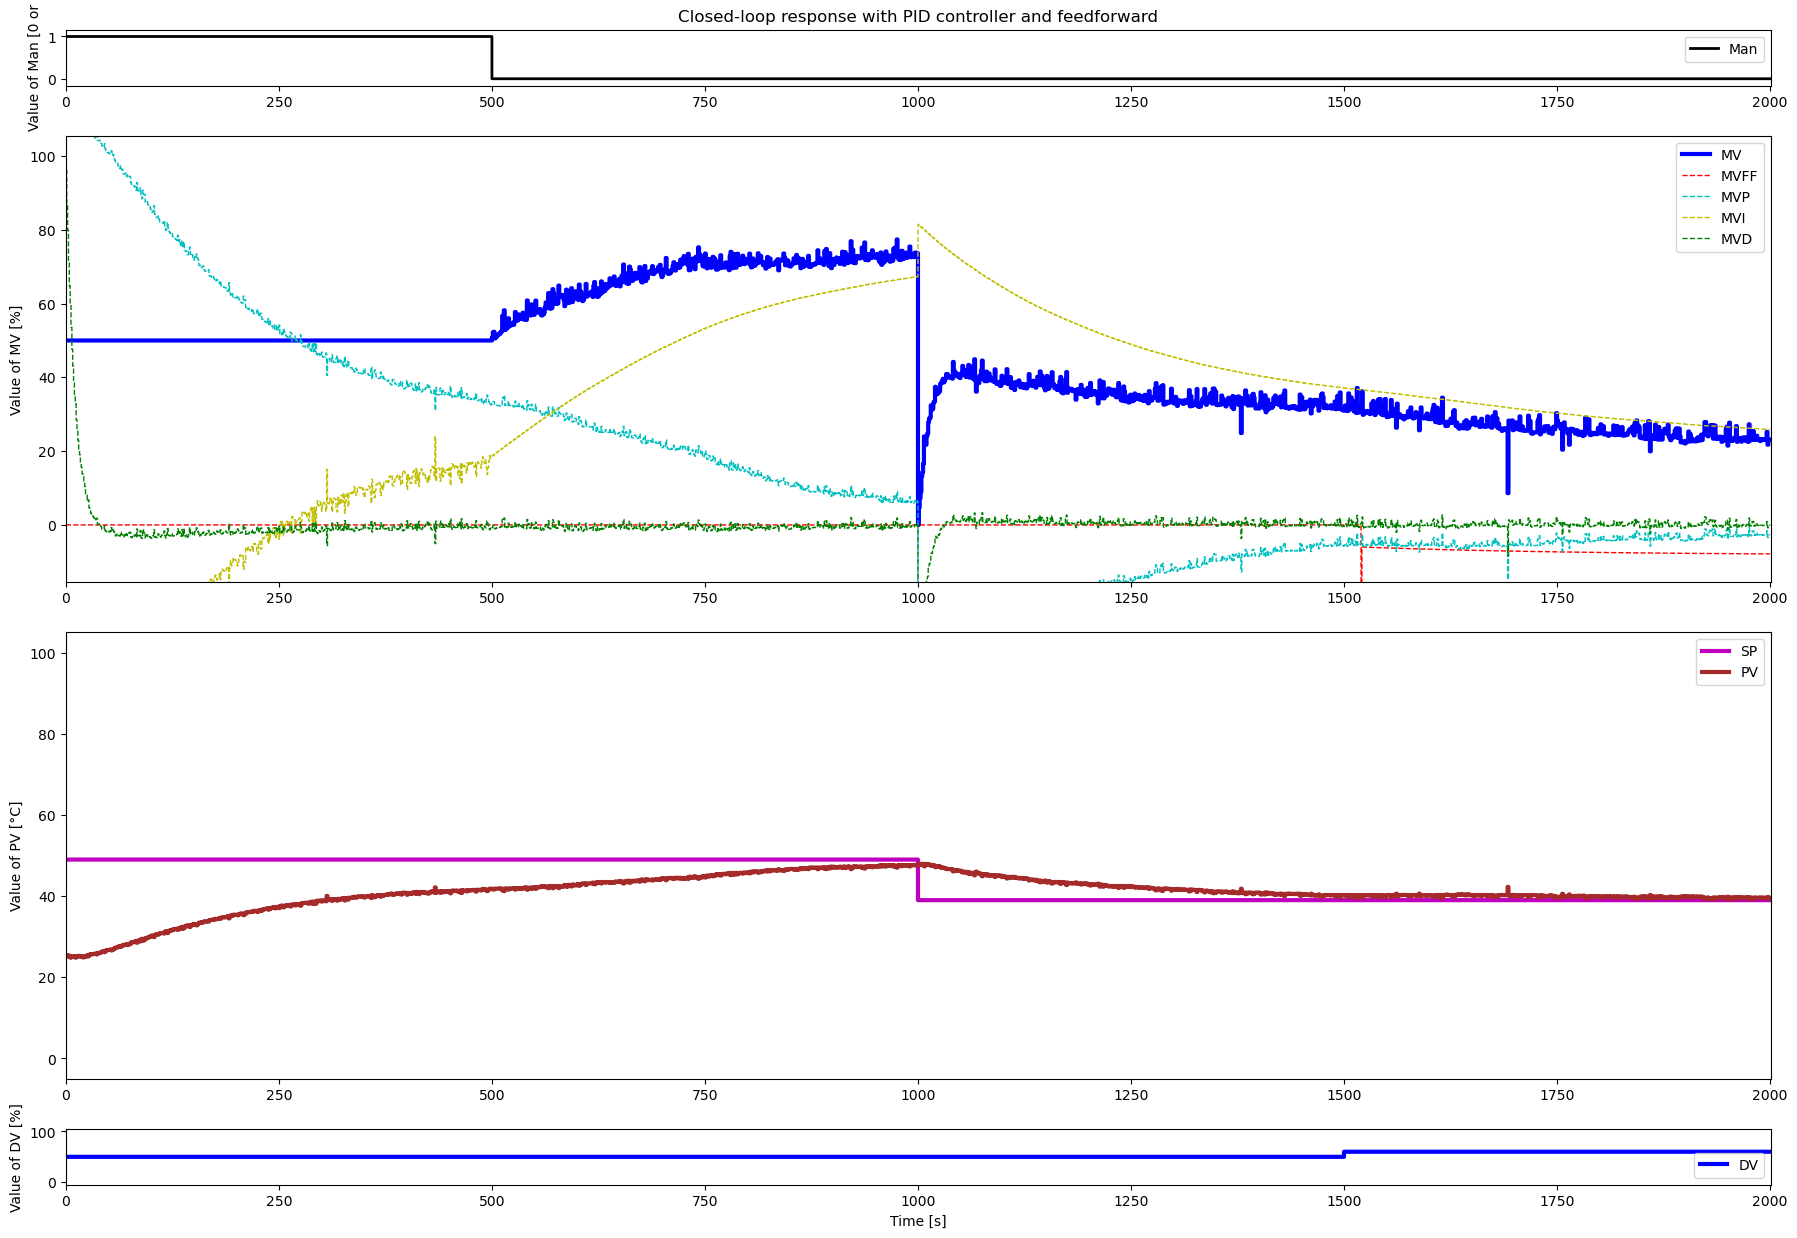

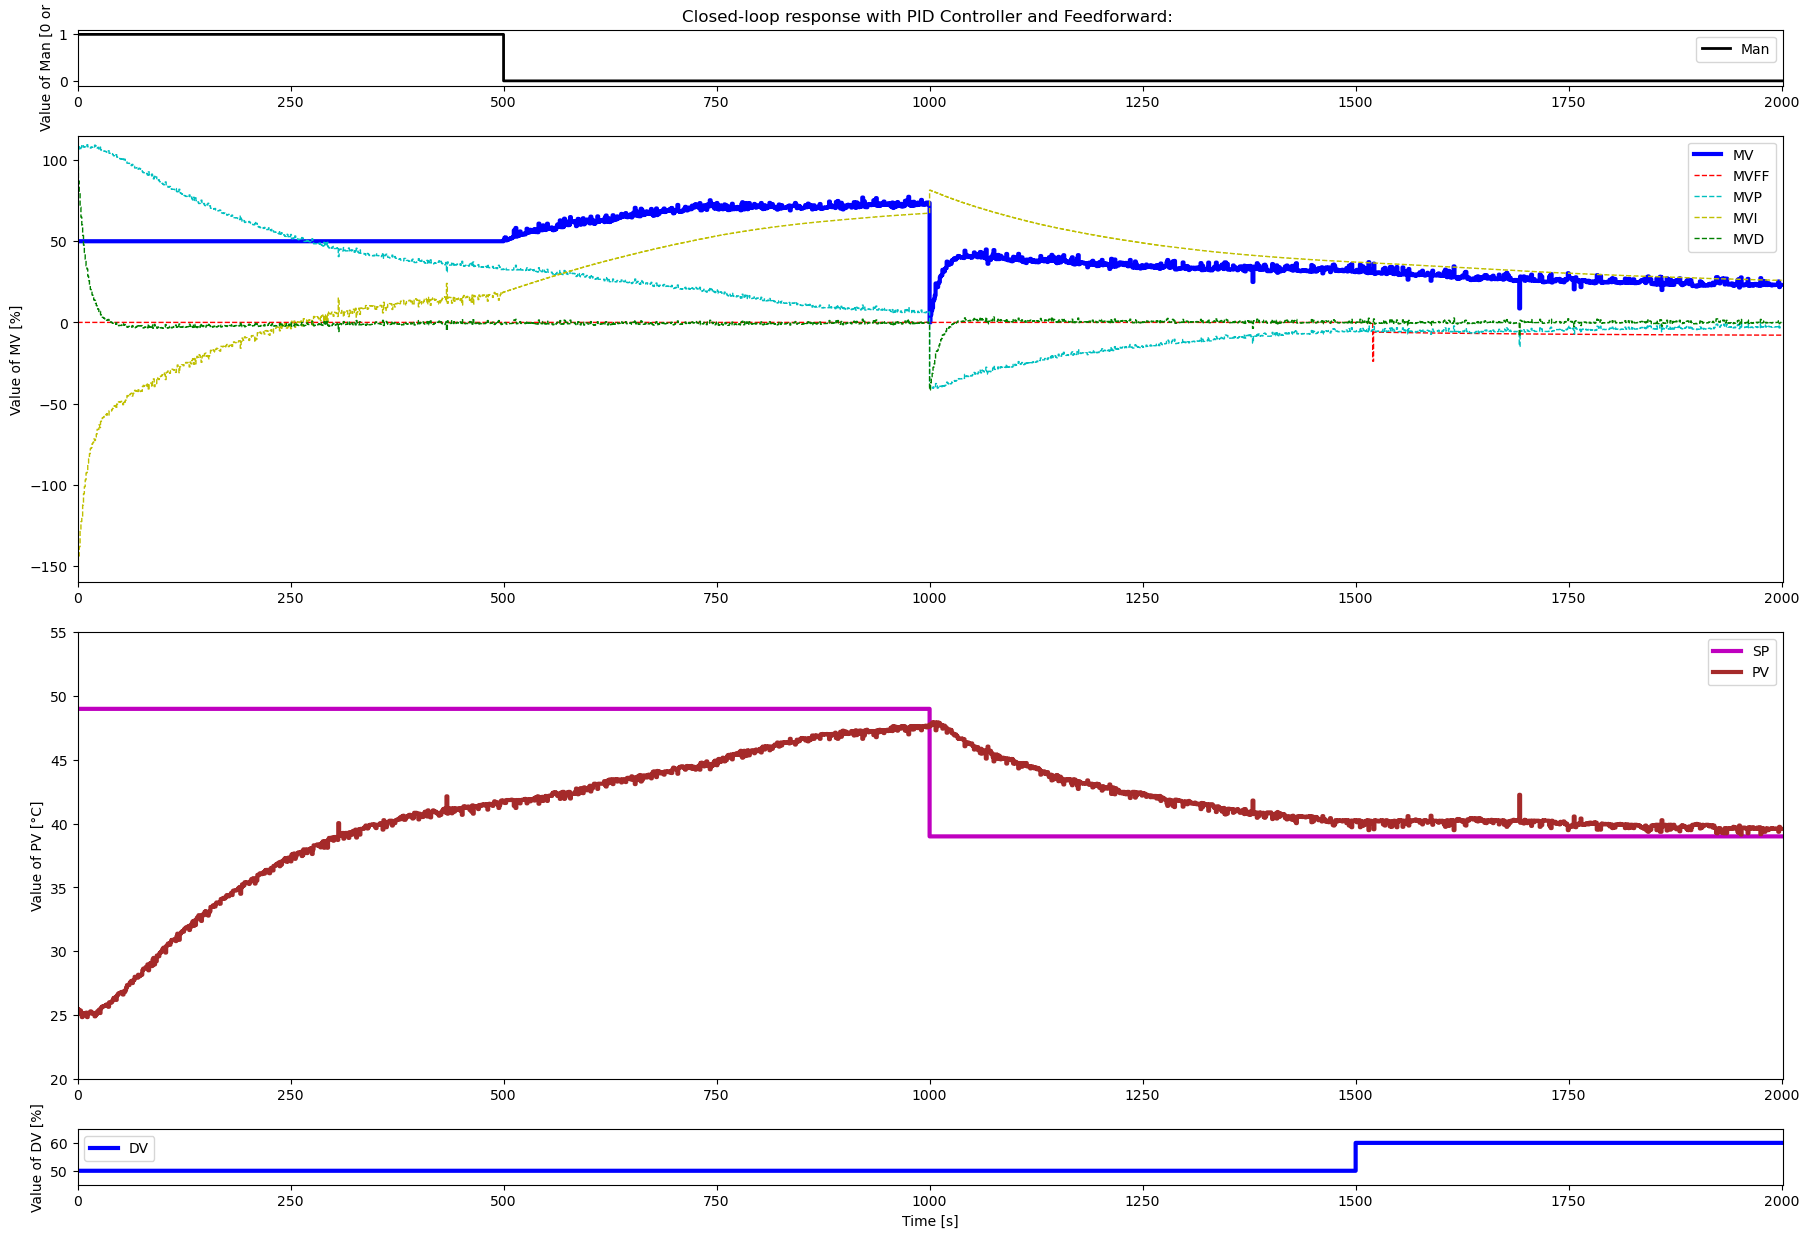

In [5]:
t = []
SP = []
DV = []
PV = []
MV = []
MVP = []
MVI = []
MVD = []
E = []
MAN = []
MVMan = []
MVFF = []

MVFFdelay = [] 
MVFFLL1 = []

MVMin = 0
MVMax = 100

# Fermer la connexion existante à l'appareil TCLab s'il y en a une
if 'lab' in locals():
    lab.close()

# Créer une nouvelle instance de la classe TCLab
lab = tclab.TCLab()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,gridspec_kw={'height_ratios':[1, 8, 8, 1]}) ##Prépare les zones des graphes
fig.set_figheight(15)
fig.set_figwidth(22)


l1, = ax1.step([0,TSim],[-0.1,1.1],'k-',linewidth=2,label="Man",where='post')  ##Graphe pour MAN
ax1.set_ylabel('Value of Man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and feedforward')
ax1.legend(loc='best')


l2, = ax2.step([0,TSim],[-10,100],'b-',linewidth=3,label="MV",where='post')    ##Graphe pour MV,MVFF,MVP,MVI,MVD
l2_1, = ax2.step([0,TSim],[-10,100],'--r',linewidth=1,label="MVFF",where='post')
l2_2, = ax2.step([0,TSim],[-10,100],'--c',linewidth=1,label="MVP",where='post')
l2_3, = ax2.step([0,TSim],[-10,100],'--y',linewidth=1,label="MVI",where='post')
l2_4, = ax2.step([0,TSim],[-10,100],'--g',linewidth=1,label="MVD",where='post')
ax2.set_ylabel("Value of MV [%]")
ax2.legend(loc='best')



l3, = ax3.step([0,TSim],[0,100],'m-',linewidth=3,label="SP",where='post')  ##Graphe pour SP,PV tjr sur le m graphe
l4, = ax3.step([0,TSim],[0,100],'brown',linewidth=3,label="PV",where='post')
ax3.set_ylabel("Value of PV [°C]")
ax3.legend(loc='best')


l5, = ax4.step([0,TSim],[0,100],'b-',linewidth=3,label="DV",where='post') ##Graphe pour DV
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Value of DV [%]")
ax4.legend(loc='best')

for i in range(0,N):
    t.append(i*Ts)
    if t[-1] == 0 :
        precedent = time.time()
        
    PV.append(lab.T1)
    
    #créer les chemins
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV) 
    SelectPath_RT(ManPath,t,MAN) 
    SelectPath_RT(MVManPath,t,MVMan)
    
    lab.Q2(DV[-1])
    
   #FeedForward
    if ActivateFF:
        gain2LL = 1
    else : 
        gain2LL = 0

    Delay_RT(DV -  DV0*np.ones_like(DV), np.max([thetad-thetap,0]), Ts, MVFFdelay)
    LeadLag_RT(MVFFdelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    LeadLag_RT(MVFFLL1, gain2LL, T2p, T2d, Ts, MVFF)
    
    #PID
    PID_RT(SP,PV,MAN,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,'EBD-EBD')
    
    lab.Q1(MV[-1])
    
    #Timing
    actual = time.time()
    time2execute = actual - precedent
    
    time.sleep(np.max([0, Ts-time2execute]))
    precedent = time.time()
    
    #data in graphic
    l1.set_data(t,MAN)
    l2.set_data(t,MV)
    l2_1.set_data(t,MVFF)
    l2_2.set_data(t,MVP)
    l2_3.set_data(t,MVI)
    l2_4.set_data(t,MVD)
    l3.set_data(t,SP)
    l4.set_data(t,PV)
    l5.set_data(t,DV)
    
    clear_output(wait=True)
    
    ax1.set_xlim(0, t[-1]+1) 
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    display(fig)


ax1.set_ylim(-0.1,1.1)
ax1.set_title('Closed-loop response with PID Controller and Feedforward: ')
MVLimMin = myRound(np.min((np.min(MV),np.min(MVP),np.min(MVI),np.min(MVD),np.min(MVFF))),5)
MVLimMax = myRound(np.max((np.max(MV),np.max(MVP),np.max(MVI),np.max(MVD), np.max(MVFF))), 5)
ax2.set_ylim(MVLimMin-5,MVLimMax+5)
ax3.set_ylim(myRound(np.min((np.min(PV),np.min(SP))),5)-5,myRound(np.max((np.max(PV),np.max(SP))),5)+5)
ax4.set_ylim(myRound(np.min(DV),5)-5,myRound(np.max(DV),5)+5)

nameFile = 'Plots/Closed_loop_experiment_PID_FF4' #1 or 2 or 3 or 4 before
plt.savefig(nameFile + '.png', transparent=True)
plt.savefig(nameFile + '.pdf', transparent=True)

#Save Data
t = np.array(t)
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
MVFF = np.array(MVFF)
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
MAN = np.array(MAN)
mydata = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,MVFF.T,SP.T,PV.T,DV.T,MAN.T))
my_data = mydata.T
nameFile = 'Data/Closed_loop_experiment_with_PID_and_FF4' + '.txt'  #1 or 2 or 3 or 4 before + .txt
np.savetxt(nameFile,my_data,delimiter=', ' ,header='t,MV,MVP,MVI,MVD,MVFF,SP,PV,DV,Man', comments="")